<a href="https://colab.research.google.com/github/BenJTowers/Cifar-10-Classifier/blob/main/CifarClassifierPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


In [6]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [7]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform  # use augmentations
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform   # no augmentations
)

100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


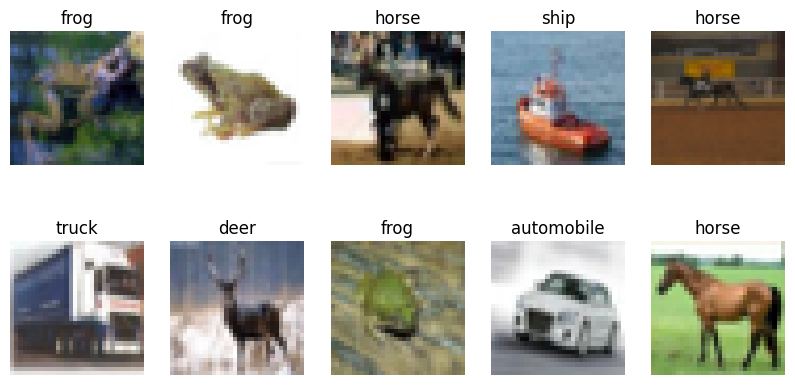

In [10]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Get another batch of training images
images, labels = next(data_iter)

# Unnormalize images
def unnormalize(img, mean, std):
    for c in range(3):  # for each channel
        img[c, :, :] = img[c, :, :] * std[c] + mean[c]
    return img

# Display images in a grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create 2x5 grid
for i, ax in enumerate(axes.flat):
    img = unnormalize(images[i],mean,std)  # Unnormalize first 10 images
    img = np.transpose(img, (1, 2, 0))  # Convert from [C, H, W] to [H, W, C]

    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])  # Show class name
    ax.axis('off')  # Hide axes for better visualization

plt.show()

In [8]:
#Model with four convolutional layers seperated into two blocks
#Uses batch normalization between each convolution to keep the inputs more stable
#Max pool after each block to reduce size and complexity
#Dropout introduced do reduce overfitting
#use relu for simplicity and to avoud saturation

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)

        # Fully Connected Layers
        # After two pools, 32x32 -> 8x8 => 64 channels * 8 * 8 = 4096
        self.fc1     = nn.Linear(64 * 8 * 8, 256)
        self.bn_fc1  = nn.BatchNorm1d(256)
        self.fc2     = nn.Linear(256, 10)

        # Dropout for regularization
        self.dropout_conv = nn.Dropout2d(p=0.25)  # in conv layers
        self.dropout_fc   = nn.Dropout(p=0.5)     # in fully connected layers

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)

        x = nn.functional.max_pool2d(x, 2)  # 32x32 -> 16x16
        x = self.dropout_conv(x)

        # Block 2
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.functional.relu(x)

        x = nn.functional.max_pool2d(x, 2)  # 16x16 -> 8x8
        x = self.dropout_conv(x)

        # Flatten for fully connected
        x = x.view(-1, 64 * 8 * 8)

        # FC layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = nn.functional.relu(x)

        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = CIFAR10Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


EPOCHS = 25  # Start with 10; you can go higher for better accuracy

for epoch in range(EPOCHS):
    model.train()  # set to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()            # clear gradients
        outputs = model(inputs)          # forward pass
        loss = criterion(outputs, labels)# compute loss
        loss.backward()                  # backprop
        optimizer.step()                 # update weights

        running_loss += loss.item()
        if (i+1) % 100 == 0:  # print every 100 batches
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Evaluation on the test set after each epoch
    model.eval()  # set to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] Test Accuracy: {accuracy:.2f}%")

print("Finished Training!")


Using device: cuda
Epoch [1/25], Step [100/782], Loss: 2.1802
Epoch [1/25], Step [200/782], Loss: 1.9815
Epoch [1/25], Step [300/782], Loss: 1.8870
Epoch [1/25], Step [400/782], Loss: 1.8149
Epoch [1/25], Step [500/782], Loss: 1.7749
Epoch [1/25], Step [600/782], Loss: 1.7540
Epoch [1/25], Step [700/782], Loss: 1.7154
Epoch [1/25] Test Accuracy: 47.93%
Epoch [2/25], Step [100/782], Loss: 1.6706
Epoch [2/25], Step [200/782], Loss: 1.6534
Epoch [2/25], Step [300/782], Loss: 1.6507
Epoch [2/25], Step [400/782], Loss: 1.6241
Epoch [2/25], Step [500/782], Loss: 1.6244
Epoch [2/25], Step [600/782], Loss: 1.5839
Epoch [2/25], Step [700/782], Loss: 1.5846
Epoch [2/25] Test Accuracy: 52.75%
Epoch [3/25], Step [100/782], Loss: 1.5587
Epoch [3/25], Step [200/782], Loss: 1.5397
Epoch [3/25], Step [300/782], Loss: 1.5290
Epoch [3/25], Step [400/782], Loss: 1.5308
Epoch [3/25], Step [500/782], Loss: 1.5336
Epoch [3/25], Step [600/782], Loss: 1.5023
Epoch [3/25], Step [700/782], Loss: 1.5083
Epoch [3

In [13]:
class DeeperCIFAR10Net(nn.Module):
    def __init__(self):
        super(DeeperCIFAR10Net, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)

        # NEW: Extra block for slightly deeper network
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(128)

        # After 3 pools, image goes from 32x32 -> 4x4
        # Final channels = 128, so flatten size = 128 * 4 * 4 = 2048
        self.fc1 = nn.Linear(128*4*4, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

        # Dropout with higher rates for stronger regularization
        self.dropout_conv = nn.Dropout2d(p=0.4)  # conv layers
        self.dropout_fc   = nn.Dropout(p=0.6)    # fully connected layers

    def forward(self, x):
        # Block 1
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)  # 32->16
        x = self.dropout_conv(x)

        # Block 2
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = nn.functional.max_pool2d(x, 2)  # 16->8
        x = self.dropout_conv(x)

        # Block 3 (extra block)
        x = nn.functional.relu(self.bn5(self.conv5(x)))
        x = nn.functional.relu(self.bn6(self.conv6(x)))
        x = nn.functional.max_pool2d(x, 2)  # 8->4
        x = self.dropout_conv(x)

        # Flatten
        x = x.view(-1, 128*4*4)

        # FC layers
        x = nn.functional.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = DeeperCIFAR10Net().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# StepLR reduces LR by a factor (gamma=0.1) every step_size epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 25

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print every 100 batches
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

    # Update the scheduler each epoch
    scheduler.step()

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] Test Accuracy: {accuracy:.2f}%")

print("Finished Training!")

Using device: cuda
DeeperCIFAR10Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, af